<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Implementación de una red GAN con Keras<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-03-14</small></i></div>
                                                  

***

## Introducción

Las redes generativas adversariales (GAN, de _Generative Adversarial Networks_) fueron presentadas por primera vez por Goodfellow et al. en el artículo [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) publicado en 2014. Este tipo de redes pueden ser utilizadas para la generación sintética de datos prácticamente idénticos a los originales.

Para la generación de estos datos se usan dos redes neuronales durante el entrenamiento: la **generadora**, que acepta un vector de entrada de ruido generado aleatoriamente y produce los datos de salida de aspecto similar a los datos auténticos, y la **discriminadora**, que intenta determinar si los datos que se le presentan son auténticos o generados.

Entrenando estas redes al mismo tiempo, una retroalimentando a la otra, dispondremos de un medio para generar datos prácticamente indistinguibles de los originales, o visto de otro modo, dispondremos de un medio para determinar si unos determinados datos son verdaderos o _fake_.

## Objetivos

Vamos a implementar una GAN simple que entrenaremos con el conjunto de datos `mnist`.

Una vez consideremos que el modelo está correctamente entrenado, usaremos la red generadora del modelo para generar nuevos números los cuales serán (esperemos) completamente originales.

## Imports y configuración

A continuación importaremos las librerías que se usarán a lo largo del notebook.

In [1]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Asímismo, configuramos algunos parámetros para adecuar la presentación gráfica.

In [2]:
%matplotlib notebook
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (15, 8),'figure.dpi': 64})

***

## El dataset que usaremos

Usaremos el _dataset_ `mnist`, que nos viene genial para un montón de tareas. Primero definiremos unas constantes que usaremos a lo largo del notebook para referirnos a datos del _dataset_.

In [3]:
WIDTH, HEIGHT, CHANNELS = 28, 28, 1

Como a lo que nos vamos a dedicar es a generar datos, la verdad es que nos dan un poco igual las labels. Nuestro objetivo aquí es que las dos redes aprendan a generar números manuscritos y a discernir si son o no originales, respectivamente.

Por tanto, cargaremos los ejemplos de entrada para el conjunto de entrenamiento y de _test_ y los combinaremos en uno sólo.

In [4]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
dataset = np.concatenate((x_train, x_test))

print(f'Real images: {dataset.shape}')

Real images: (70000, 28, 28)


## Red generadora

La parte generadora de un modelo GAN se encarga de generar datos nuevos a partir de ruido aleatorio. Es de esperar que, a la larga, sea capaz de generar nuevos datos con una distribución similar a la de los elementos reales.

Y ya que hemos dicho _ruido aleatorio_, vamos con la definición de la longitud del vector de valores de entrada de ruido.

In [5]:
HIDDEN_FEATURES = 64

A continuación definimos una función que nos devolverá una red generadora.

In [6]:
def create_generator(hidden_features, output_shape):
    return tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_shape=(hidden_features,)),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.Dense(WIDTH*HEIGHT*CHANNELS, activation='sigmoid'),
        tf.keras.layers.Reshape(output_shape)
    ], name='Generator')

Esta red toma como entrada un vector de la longitud definida en la variable `HIDDEN_FEATURES`, y como salida dará una imagen del tamaño de la del conjunto de datos.

Una vez definida la función, creamos la red generadora que formará parte del modelo GAN.

In [7]:
generator = create_generator(HIDDEN_FEATURES, (WIDTH, HEIGHT, CHANNELS))
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Red discriminadora

Al igual que con la generadora, definiremos una función que crea una red discriminadora.

NOTA: Es posible poner un dropout tras la salida

In [17]:
def create_discriminator(input_shape,):
    return tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
        tf.keras.layers.Dropout(0.9),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        tf.keras.layers.Dropout(0.5),
    ], name='Discriminator')

Si observamos un poco la estructura, hemos añadido bastante regularización. El `mnist` es un problema muy simple, y la discriminadora es capaz de determinar muy rápidamente las características que hacen a una imagen real, por lo que aprende muy rápido a discrimiar, impidiendo que la red generadora aprenda.

Ua vez definida la función, creamos la red discriminadora que formará parte de nuestro modelo.

In [18]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable


In [19]:
discriminator = create_discriminator(input_shape=(WIDTH, HEIGHT, CHANNELS))
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Definición de la arquitectura GAN

Ya disponemos de una red generadora y otra discriminadora. Ahora, antes de realizar la composición del modelo completo, compilaremos el discriminador para luego impedir el entrenamiento de sus pesos en el resto del modelo

In [20]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.trainable = False

A partir de este punto, cualquier modelo que use el discriminador, durante el paso de actualización de los parámetros la red discriminadora **no verá alterados sus pesos**. La única manera que existe ahora mismo de actualizar los pesos de la red discriminadora es invocando su grafo explícitamente.

El siguiente paso es crear la estructura donde se conectan las redes generadora y discriminadora y crear un nuevo modelo.

In [21]:
z = tf.keras.layers.Input(shape=(HIDDEN_FEATURES,))
validity = discriminator(generator(z))

combined = tf.keras.models.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer='adam')

El modelo `combined` es nuestro modelo GAN, y se invocará cuando queramos entrenar a la red generadora del modelo. 

Cuando vayamos a entrenar a la red generadora, lo haremos a través de este modelo, dando como entrada un vector de ruido y como salida siempre 1 (es decir, diciéndole al modelo que la imagen es real). Durante la actualización de pesos **no se tocará el discriminador**, sino que sólo se verán afectados los pesos de la red generadora.

## Entrenamiento del modelo GAN

Ahora sí, podemos proceder al entrenamiento. A modo de resume, el proceso es el siguiente:

1. Creamos un `ImageDataGenerator` sobre el conjunto de datos de imágenes que nos estará dando constantemente _batchs_ de un tamaño determinado sin parar, comenzando desde el principio si llega al final.
1. Luego, en un bucle infinito:
    1. Tomará un batch de imágenes reales $\mathcal{R}$.
    2. Generará un batch de vectores de ruido aleatorio del mismo tamaño y, a partir de él, un batch de imágenes ficticias $\mathcal{F}$.
    3. Entrenará al discriminador indicando que $\mathcal{R}$ son verdaderas y $\mathcal{F}$ son falsas.
    4. Entrenará al generador indicando que $\mathcal{F}$ son verdaderas

<IPython.core.display.Javascript object>


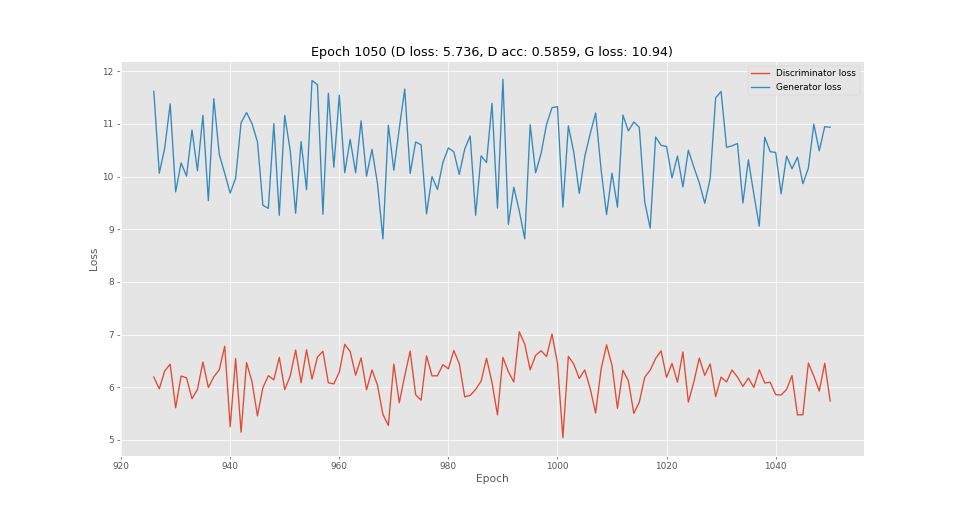

KeyboardInterrupt: 

In [23]:
def train(dataset, generator, discriminator, combined, sample_interval=100, window=None):
    window = window or sample_interval * 5
    # Para la salida de la gráfica por pantalla
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('Task')
    ax.set_ylabel('Reward')
    
    # Añadimos una dimensión porque lo requiere el datagenerator
    dataset = dataset.reshape(*dataset.shape, CHANNELS)
    # Creamos un datagenerator para que nos vaya dando pequeños batches de
    # entrenamiento
    data_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow(
        dataset,
        batch_size=64,
        shuffle=True
    )

    history = {
        'epoch': collections.deque(maxlen=window),
        'd_loss' : collections.deque(maxlen=window),
        'd_acc' : collections.deque(maxlen=window),
        'g_loss' : collections.deque(maxlen=window),
    }

    epoch = 0
    for epoch, real_batch in enumerate(data_generator):
        # Creamos las etiquetas de imagenes válidas y no válidas para el batch
        fake_labels = np.zeros((real_batch.shape[0], 1))
        real_labels = np.ones((real_batch.shape[0], 1))

        # Creamos un batch del mismo tamaño que el original, pero con imágenes
        # falsas. Cada una se creará a partir de un vector de características
        # diferente
        
        noise = np.random.random( (real_batch.shape[0], HIDDEN_FEATURES))
        #noise = np.random.normal(0, 1, (real_batch.shape[0], HIDDEN_FEATURES))
        fake_batch = generator.predict(noise, verbose=0)

        # Entrenamos el discriminador con las imágenes verdaderas y falsas
        discriminator_loss_real = discriminator.train_on_batch(real_batch, real_labels)
        discriminator_loss_fake = discriminator.train_on_batch(fake_batch, fake_labels)
        discriminator_loss = .5 * np.add(discriminator_loss_real, discriminator_loss_fake)

        # Entrenamos el generador sólo con las imágenes falsas (diciendo que
        # son verdaderas)
        #noise = np.random.normal(0, 1, (real_batch.shape[0], HIDDEN_FEATURES))
        generator_loss = combined.train_on_batch(noise, real_labels)

        history['epoch'].append(epoch)
        history['d_loss'].append(discriminator_loss[0])
        history['d_acc'].append(discriminator_loss[1])
        history['g_loss'].append(generator_loss)

        # Pintamos las gráficas
        if epoch % sample_interval == 0:
            ax.cla()
            ax.set_title(f'Epoch {epoch} (D loss: {discriminator_loss[0]:.4}, D acc: {discriminator_loss[1]:.4}, G loss: {generator_loss:.4})')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')

            ax.plot(history['epoch'], history['d_loss'], label='Discriminator loss')
            ax.plot(history['epoch'], history['g_loss'], label='Generator loss')
            ax.legend()
            fig.canvas.draw()
            #generator.save('tmp/generator.h5')
            #discriminator.save('tmp/discriminator.h5')
        epoch += 1


train(dataset, generator, discriminator, combined, sample_interval=25)

Tras parar (manualmente) el entrenamiento, podemos echar un ojo a algunas de las imágenes generadas por la red generadora.

In [24]:
noise = np.random.normal(0, 1, (5, HIDDEN_FEATURES))
images = generator(noise)

fig, ax = plt.subplots(1,5, figsize=(15, 5))
for i, image in enumerate(images):
    ax[i].imshow(image)
    ax[i].axis('off')
plt.show()

<IPython.core.display.Javascript object>

## Conclusiones

Hemos aprendido a implementar una red GAN desde cero (bueno, usando Keras, pero se me entiende) y hemos podido explorar algunos de sus desafíos. En particular, hemos observado lo complicado que es conseguir que ambas redes, el generador y el discriminador, converjan correctamente.

Ahora ya somos capaces de empezar a ver los desafíos que existen en estos tipos de redes (como por ejemplo el maldito colapso modal después de haber sufrido la discriminadora perfecta), cómo se ajustan los hiperparámetros y, en definitiva, cuál es la base en la que se apoyan las técnicas de redes generativas adversariales.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>